In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip3 install -U 'gast==0.2.2'
#pip install -U gast==0.2.2

Requirement already up-to-date: gast==0.2.2 in /usr/local/lib/python3.6/dist-packages (0.2.2)


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [0]:
tf.__version__

'2.0.0-rc0'

In [0]:
#ruta raiz
PATH = "/content/drive/My Drive/proyectos_redes_neuronales/tarjeta_pix2pix"
#entrada

INPATH = PATH + '/INPUT'
OUPATH = PATH + '/TARGET'

#ruta de los checkpoints
CKPATH = PATH + '/checkpoints'


imgurls = !ls -1 "{INPATH}"
imgurls

['image_00001.jpg',
 'image_00002.jpg',
 'image_00003.jpg',
 'image_00004.jpg',
 'image_00005.jpg',
 'image_00006.jpg',
 'image_00007.jpg',
 'image_00008.jpg',
 'image_00009.jpg',
 'image_00010.jpg',
 'image_00011.jpg',
 'image_00012.jpg',
 'image_00013.jpg',
 'image_00014.jpg',
 'image_00015.jpg',
 'image_00016.jpg',
 'image_00017.jpg',
 'image_00018.jpg',
 'image_00019.jpg',
 'image_00020.jpg',
 'image_00021.jpg',
 'image_00022.jpg',
 'image_00023.jpg',
 'image_00024.jpg',
 'image_00025.jpg',
 'image_00026.jpg',
 'image_00027.jpg',
 'image_00028.jpg',
 'image_00029.jpg',
 'image_00030.jpg',
 'image_00031.jpg',
 'image_00032.jpg',
 'image_00033.jpg',
 'image_00034.jpg',
 'image_00035.jpg',
 'image_00036.jpg',
 'image_00037.jpg',
 'image_00038.jpg',
 'image_00039.jpg',
 'image_00040.jpg',
 'image_00041.jpg',
 'image_00042.jpg',
 'image_00043.jpg',
 'image_00044.jpg',
 'image_00045.jpg',
 'image_00046.jpg',
 'image_00047.jpg',
 'image_00048.jpg',
 'image_00049.jpg',
 'image_00050.jpg',


In [0]:
n = 100
train_n = round (n * 0.80)
# listado randomizado
randurls = np.copy (imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

# particiones train/ test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]
print (len(imgurls), len(tr_urls),len(ts_urls)  )

100 80 20


In [0]:
# redimensionar las imagnes
IMG_WIDTH = 256
IMG_HEIGHT = 256
#256

def resize(inimg, tgimg, height, width):
    inimg = tf.image.resize( inimg,[height,width] )
    tgimg = tf.image.resize( tgimg,[height,width] )
    return inimg, tgimg

# normalizar las imagenes que son de 0 - 255 .. a que sean de -1 a 1
# normaliza al rango [-1,+1] la imagen 
# solo la division hace que este en rango de 0 a 2 .. y restarle uno hace que sea de -1 a 1
def normalize (inimg,tgimg):
    inimg = (inimg / 127.5) -1
    tgimg = (tgimg / 127.5) -1
    return inimg, tgimg

# aumentacion de datos : random crop + flit
# aumentar mas imagenes solo con variaciones random pequeñas ... para un mejor entrenamiento

def random_jitter(inimg, tgimg):
    inimg , tgimg = resize(inimg, tgimg, 286, 286)
    
#     apilar las imagenes juntas .. para que tengan las mismas dimensiones,, con eje 0 (axis)
    stacked_image = tf.stack( [inimg, tgimg], axis = 0 ) # hace que sea de dimension 2x286x286.. por ser dos imagenes
    cropped_image = tf.image.random_crop( stacked_image, size=[2,IMG_HEIGHT, IMG_WIDTH, 3] )
    
    inimg , tgimg = cropped_image[0],cropped_image[1]
    
    if tf.random.uniform(()) > 0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)
        
    return inimg , tgimg

def load_image(filename, augment=True):
    inimg = tf.cast( tf.image.decode_jpeg( tf.io.read_file(INPATH + '/' + filename) ), tf.float32 )[..., :3]
    tgimg = tf.cast( tf.image.decode_jpeg( tf.io.read_file(OUPATH + '/' + filename) ), tf.float32 )[..., :3]
    
    inimg,tgimg = resize(inimg , tgimg,  IMG_HEIGHT, IMG_WIDTH)
    
    if augment:
        inimg, tgimg = random_jitter(inimg,tgimg)
    
    inimg, tgimg = normalize (inimg, tgimg)
    return inimg, tgimg

def load_train_image(filename):
    return load_image(filename,True)
def load_test_image(filename):
    return load_image(filename,False)


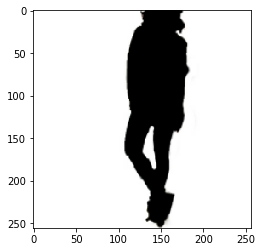

In [0]:
plt.imshow( (load_train_image(randurls[4])[0] +1) /2)
# se le suma y divide porque plt.imshow acepta rangos de 0 a 1... y el nuestro era de -1 a 1

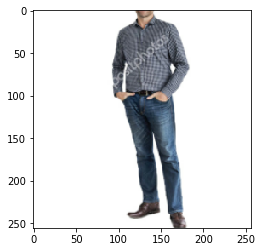

In [0]:
plt.imshow( (load_train_image(randurls[0])[1] +1) /2)

In [0]:
# crear un data set a partir de un listado de elementos que se especifique
train_dataset = tf.data.Dataset.from_tensor_slices( tr_urls )
train_dataset = train_dataset.map( load_train_image,num_parallel_calls = tf.data.experimental.AUTOTUNE )
train_dataset = train_dataset.batch( 1 )

# crear un data set a partir de un listado de elementos que se especifique
test_dataset = tf.data.Dataset.from_tensor_slices( ts_urls )
# test_dataset = tf.data.Dataset.from_tensor_slices( tr_urls )
test_dataset = test_dataset.map( load_test_image,num_parallel_calls = tf.data.experimental.AUTOTUNE )
test_dataset = test_dataset.batch( 1 )

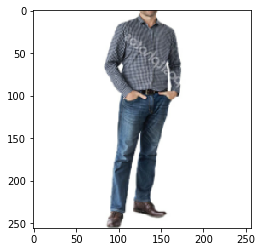

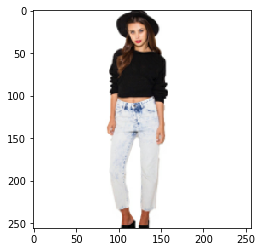

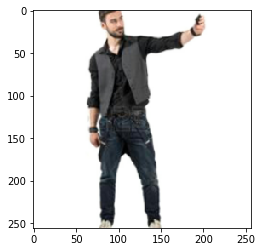

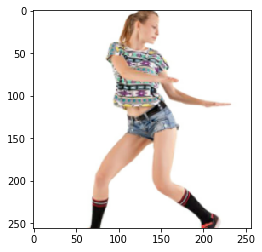

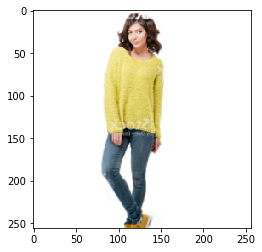

In [0]:
for inimg, tgimg in train_dataset.take(5):
    plt.imshow( ( (tgimg[0,...])+1 )/2 )
    plt.show()

In [0]:
# importar dentro del modulo de keras, todas las capas para facilitar el trabajo
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm = True):
    # indica a keras que lo que viene luego .. es una secuencia de capas
    result = Sequential()
    initializer = tf.random_normal_initializer(0,0.02) # parametros media y desviacion estandar
    
#     capa convolucional
    result.add( Conv2D(filters,
                        kernel_size = 4,
                        strides = 2,
                        padding = "same",
                        kernel_initializer = initializer,
                        use_bias = not apply_batchnorm))
#     capa de batch, normalization
    if apply_batchnorm:
#         capa de batchNorm
        result.add(BatchNormalization())
#     capa de activation
    result.add( LeakyReLU() )
    return result

downsample(64)

In [0]:
def upsample(filters, apply_dropout = False):
    # indica a keras que lo que viene luego .. es una secuencia de capas
    result = Sequential()
    initializer = tf.random_normal_initializer(0,0.02) # parametros media y desviacion estandar
    
#     capa convolucional
    result.add( Conv2DTranspose(filters,
                                kernel_size = 4,
                                strides = 2,
                                padding = "same",
                                kernel_initializer = initializer,
                                use_bias = False))
    #capa de batchNorm
    result.add(BatchNormalization())

    if apply_dropout:
        #capa de dropout
        result.add( Dropout(0.5) )
        
#     capa de activation
    result.add( ReLU() )
    return result

upsample(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


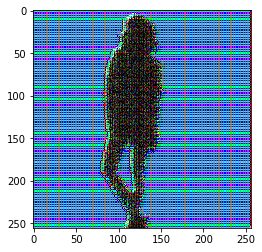

In [0]:
def Generator():
    inputs = tf.keras.layers.Input( shape=[None,None,3] )
    
    down_stack = [
        downsample(64, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128),                        # (bs, 64,  64,  128)
        downsample(256),                        # (bs, 32,  32,  256)
        downsample(512),                        # (bs, 16,  16,  512)
        downsample(512),                        # (bs, 8,   8,   512)
        downsample(512),                        # (bs, 4,   4,   512)
        downsample(512),                        # (bs, 2,   2,   512)
        downsample(512),                        # (bs, 1,   1,   512)
    ]
    
    
    up_stack = [
        upsample(512, apply_dropout=True),      # (bs, 2,   2,   1024)
        upsample(512, apply_dropout=True),      # (bs, 4,   4,   1024)
        upsample(512, apply_dropout=True),      # (bs, 8,   8,   1024)
        upsample(512),                          # (bs, 16,  16,  1024)
        upsample(256),                          # (bs, 32,  32,  512)
        upsample(128),                          # (bs, 64,  64,  256)
        upsample(64),                           # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0,0.02)
    
    last = Conv2DTranspose(filters = 3,
                          kernel_size= 4,
                          strides= 2,
                          padding="same",
                          kernel_initializer=initializer,
                          activation="tanh")
    # conectamos las capas ... mediante un for 
    x = inputs
    # s es para las skip conection .. esas coneciones entre capas de down y up
    s = [] 
    
    concat = Concatenate()
    
 
    
    for down in down_stack:
        x = down(x)
        s.append(x)
    
    s = reversed(s[:-1])    # el -1 es del ultimo elemento ,, que no se utiliza .. 
                            # por lo tanto se deja .. todos hasta el penultimo
    
    for up, sk in zip(up_stack, s ):
        x = up(x)
        x = concat([x, sk])
    
    last = last(x)
    
    return Model( inputs=inputs, outputs = last )
    
generator = Generator()
gen_output = generator( ( (inimg+1)*255 ),training=False )
plt.imshow(gen_output[0,...])

TensorShape([1, 16, 16, 1])

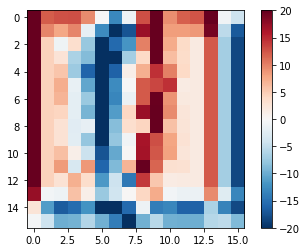

In [0]:
def Discriminator():
    ini = Input( shape=[None,None,3], name="input_img" )
    gen = Input( shape=[None,None,3], name="gener_img" )
    
    con = concatenate([ini,gen])
    
    initializer = tf.random_normal_initializer(0,0.02)
    down1 = downsample(64, apply_batchnorm=False )(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)
    
    last = tf.keras.layers.Conv2D(filters=1,
                                  kernel_size=4,
                                  strides = 1,
                                  kernel_initializer=initializer,
                                  padding="same")(down4)
    
    return tf.keras.Model(inputs=[ini,gen], outputs=last)

discriminator = Discriminator()

disc_out = discriminator( [((inimg+1)*255), gen_output], training = False )
plt.imshow( disc_out[0,...,-1], vmin = -20, vmax = 20, cmap = 'RdBu_r' )
plt.colorbar()
disc_out.shape

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy( from_logits= True )

In [0]:
def discriminator_loss ( disc_real_output, disc_generated_output ):
    #diferencia entre los true por ser real y el detectado por el discriminador
    real_loss = loss_object( tf.ones_like( disc_real_output ), disc_real_output )
    #diferencia entre los false por ser generado y el detectado por el discriminador
    generated_loss = loss_object( tf.zeros_like( disc_generated_output ), disc_generated_output )
    
    total_disc_loss= real_loss + generated_loss
    
    return total_disc_loss

In [0]:
LAMBDA = 100
def generator_loss (disc_generated_output, gen_output, target):
    gan_loss = loss_object( tf.ones_like( disc_generated_output ), disc_generated_output )
    
    #mean abosulte error
    l1_loss = tf.reduce_mean( tf.abs(target - gen_output) )
    
    total_gen_loss = gan_loss + ( LAMBDA * l1_loss)
    return total_gen_loss

In [0]:
import os 
generator_optimizer = tf.keras.optimizers.Adam( 2e-4, beta_1=0.5 )
discriminator_optimizer = tf.keras.optimizers.Adam( 2e-4, beta_1=0.5 )

checkpoint_prefix = os.path.join( CKPATH, "ckpt" )
checkpoint = tf.train.Checkpoint( generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)



In [0]:
#CHECK POINT .. RESTAURAR
checkpoint.restore( tf.train.latest_checkpoint( CKPATH ) ).assert_consumed()

AssertionError: ignored

In [0]:
def generate_images ( model, test_input, tar, save_filename=False, display_imgs=True  ):
    prediction = model( test_input, training=True )
    
    if save_filename:
        tf.keras.preprocessing.image.save_img( PATH + '/output/' + save_filename + '.jpg', prediction[0,...])
    
    plt.figure( figsize=(10,10) )
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    if display_imgs:
        for i in range (3):
            plt.subplot(1,3,i+1)
            plt.title(title[i])
            
            plt.imshow( display_list[i] * 0.5 + 0.5 )
            plt.axis('off')
    plt.show()

In [0]:
@tf.function()
def train_step( input_image, target ):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        
        output_image = generator( input_image, training = True )
        
        output_gen_discr = discriminator( [output_image, input_image], training=True )
        
        output_trg_discr = discriminator( [target, input_image], training=True )
        
        discr_loss = discriminator_loss( output_trg_discr, output_gen_discr )
        
        gen_loss = generator_loss( output_gen_discr, output_image, target )
        
        
        generator_grads = gen_tape.gradient( gen_loss, generator.trainable_variables )
        
        discriminator_grads = discr_tape.gradient( discr_loss, discriminator.trainable_variables )
        
        generator_optimizer.apply_gradients( zip(generator_grads, generator.trainable_variables) )
        
        discriminator_optimizer.apply_gradients( zip(discriminator_grads, discriminator.trainable_variables) )

In [0]:
from IPython.display import clear_output

def train (dataset, epochs):
    for epoch in range (epochs):
        imgi = 0
        for input_image, target in dataset:
            print ( 'epoch ' + str(epoch)+' - train: '+str(imgi)+'/'+str(len(tr_urls)) )
            imgi += 1
            train_step( input_image, target )
            clear_output(wait=True)
            
        imgi = 0
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi)+'_'+str(epoch),display_imgs=True)
            imgi += 1
        #saving (checkpoint) the model every 50 epochs
        if (epoch + 1) % 200 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

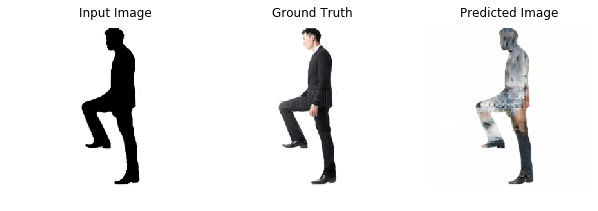

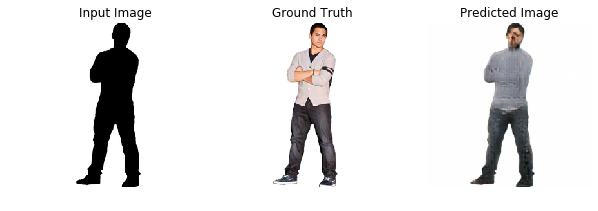

In [0]:
train(train_dataset,601)